# Recurrent Residual Convolutional Neural Network (Task3)

### Simon Laurent Lebailly, 2549365, s9sileba@teams.uni-saarland.de
### Christian Mathieu Schmidt, 2537621, s9cmscmi@teams.uni-saarland.de

## 1) Preliminaries

#### Import libaries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import cityscapesscripts as cs

#### Use CUDA if possible

In [2]:
#Check if CUDA is available, if not use the CPU.
train_on_GPU = torch.cuda.is_available()
device = torch.device('cuda' if train_on_GPU else 'cpu')

if train_on_GPU:
    print('CUDA available!')
else:
    print('CUDA not available!')

CUDA available!


#### Define Hyperparameters

In [3]:
train = True
validate = True
evaluate = True

train_bs = 12
validation_bs = 1
test_bs = 1

epochs = 10

learning_rate = 0.0002

## 2) Data

#### Import dataset Cityscapes

In [4]:
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils import data


#Define normalization for dataset
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

#Define transformation for train, validation and test dataset
transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    normalize
])

class TransformToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample_out = (sample*32).long()
        return sample_out

target_transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    TransformToTensor()
])


#Path of dataset
root_path = 'C:/Users/chris/Documents/Cityscapes_dataset/Cityscapes'

if train:
    #Import dataset for training
    train_set = datasets.Cityscapes(root=root_path, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_train = len(train_set)
    print('Quantity training data: '+ str(quantity_train))

    #Prepare training dataset for NN
    train_loader = data.DataLoader(train_set, batch_size=train_bs, shuffle=True)

if validate or evaluate:
    #Import dataset for validation
    validation_set = datasets.Cityscapes(root=root_path, split='val', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_validation = len(validation_set)
    print('Quantity validation data: '+ str(quantity_validation))

    #Prepare validation dataset for NN
    validation_loader = data.DataLoader(validation_set, batch_size=validation_bs, shuffle=True)

if evaluate:
    #Import dataset for testing
    test_set = datasets.Cityscapes(root=root_path, split='test', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_test = len(test_set)
    print('Quantity testing data: '+ str(quantity_test))

    #Prepare test dataset for NN
    test_loader = data.DataLoader(test_set, batch_size=test_bs, shuffle=True)


Quantity training data: 2975
Quantity validation data: 500
Quantity testing data: 1525


In [5]:
#Printouts for testing train set

#print(train_loader)
#print(validation_loader)
#print(test_loader)



#Tensor to image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#img = cs.csViewer
#img, segm = train_set[32]
#print(img)
#print(segm.size())
#print(segm)
#segm_norm = segm
#segm_norm = segm
#print(segm_norm.size())
#targ_min = 32
#targ_max = 0
#for b in range(0, 1):
#    for r in range(0,256):
#        for c in range(0,512):
#            #if label_mask[b][r][c] >= 32:
#                #print("First eval: " + str(label_mask[b][r][c]) + ", " + str(b) + ", " + str(r) + ", " + str(c))
#            if segm_norm[b][r][c] > targ_max:
#                targ_max = segm_norm[b][r][c]
#            if segm_norm[b][r][c] < targ_min:
#                targ_min = segm_norm[b][r][c]
#print("targ_min: " + str(targ_min))
#print("targ_max: " + str(targ_max))

#segm_norm = (segm*8)/256
#print(segm_norm)
#print(img.size())

#imshow(torchvision.utils.make_grid(img))
#imshow(torchvision.utils.make_grid(segm))

#print(segm)
#segm.show()
#print(type(train_set))
#print(train_set)

## 3) Model

#### Define R2U-Net model

In [6]:
import torch
import torch.nn as nn


# Here we have implemented the DEEPLABV3-RESNET101 architecture

class DEEPLABV3_RESNET101(nn.Module):
    def __init__(self, labels=34):
        super(DEEPLABV3_RESNET101, self).__init__()

        pass


    def forward(self, x):
        pass




In [7]:
#Load model to device
#model = DEEPLABV3_RESNET101().to(device)
#print(model)

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, progress=True, num_classes=34).to(device)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## 4) Loss and Optimizer

In [8]:
# loss function
criterion = nn.CrossEntropyLoss().to(device)

# optimizer variable
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 5) Train model

#### Definition train and validation loop

In [9]:
def show_statistics(epoch, batch_id, loss_actual, input_image, label_mask, output_model):
    print('[%d, %5d] train_loss: %.3f' % (epoch+1, batch_id+1, loss_actual.item()))

    # print images
    image2 = input_image.cpu()
    imshow(torchvision.utils.make_grid(image2[0]))

    label2 = label_mask.cpu()

    plt.imshow(label2.detach().numpy()[0])
    plt.show()

    output2 = output_model.cpu()
    output3 = output2.argmax(dim=1)

    plt.imshow(output3.detach().numpy()[0])
    plt.show()


def train_model(epoch, train_loader):
    trainloader_loop = tqdm(train_loader)
    printrate = int(quantity_train/(train_bs*10))
    train_loss = 0.0

    #Set model mode to train
    model.train()

    #Iterate over all batches in train_loader
    for i, batch in enumerate(trainloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.cuda.amp.autocast():
            output_model = model(input_image)['out']

            loss = criterion(output_model, label_mask)

            #Print with loss
            train_loss += loss.item()
            if i % printrate == 0:
                show_statistics(epoch, i, loss, input_image, label_mask, output_model)

        #Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #update tqdm
        trainloader_loop.set_postfix(loss=loss.item())

    print("Finished training!")

    #Calculate validation_loss
    train_loss = train_loss/quantity_train

    return train_loss


def validate_model(epoch, validation_loader):
    validationloader_loop = tqdm(validation_loader)
    printrate = int(quantity_validation/(validation_bs*10))
    validation_loss = 0.0

    #Set model mode to evaluation
    model.eval()

    #Iterate over all batches in validation_loader
    for i, batch in enumerate(validationloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.no_grad():
            output_model = model(input_image)['out']

            loss = criterion(output_model, label_mask)

            #Print with loss
            validation_loss += loss.item()
            if i % printrate == 0:
                show_statistics(epoch, i, loss, input_image, label_mask, output_model)

        #update tqdm
        validationloader_loop.set_postfix(loss=loss.item())

    print("Finished validation!")

    #Calculate validation_loss
    validation_loss = validation_loss/quantity_validation

    return validation_loss


#### Training and validation of the model

100%|██████████| 50/50 [00:57<00:00,  1.15s/it, loss=0.397]


[1,     1] train_loss: 3.617
[1,    30] train_loss: 0.883
[1,    59] train_loss: 0.646
[1,    88] train_loss: 0.642
[1,   117] train_loss: 0.487
[1,   146] train_loss: 0.554
[1,   175] train_loss: 0.453
[1,   204] train_loss: 0.453
[1,   233] train_loss: 0.330
[1,   262] train_loss: 0.333
[1,   291] train_loss: 0.326
Finished training!
[1,     1] train_loss: 0.389
[1,     6] train_loss: 0.374
[1,    11] train_loss: 0.407
[1,    16] train_loss: 0.350
[1,    21] train_loss: 0.428
[1,    26] train_loss: 0.388
[1,    31] train_loss: 0.418
[1,    36] train_loss: 0.414
[1,    41] train_loss: 0.421
[1,    46] train_loss: 0.448
Finished validation!
Finished train model!


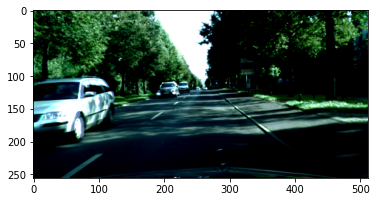

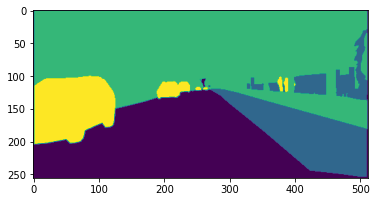

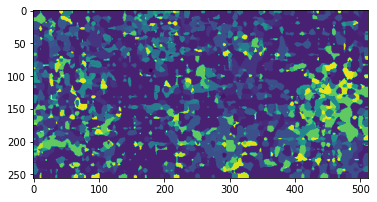

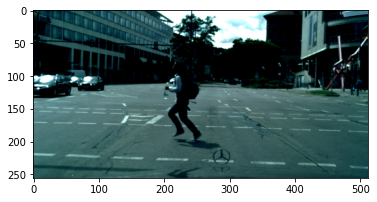

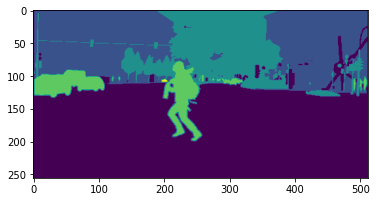

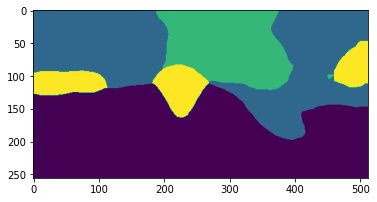

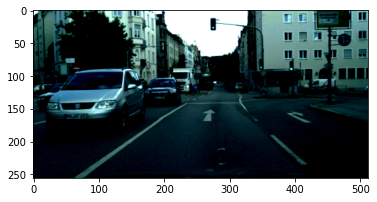

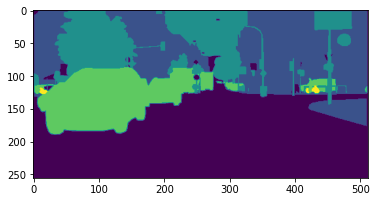

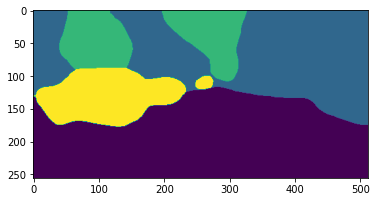

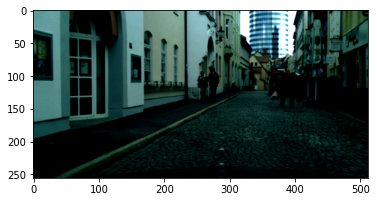

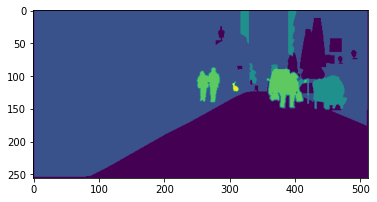

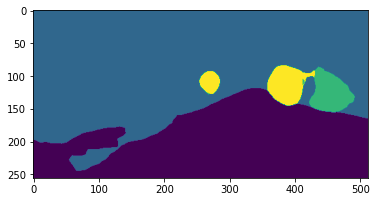

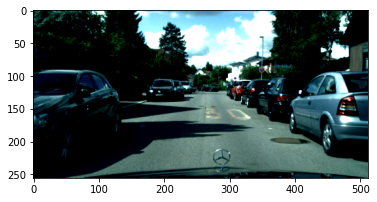

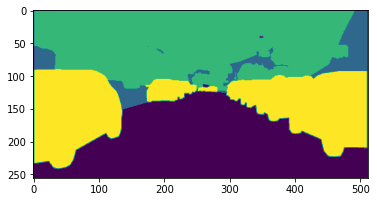

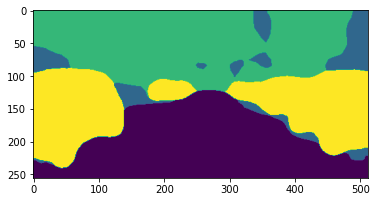

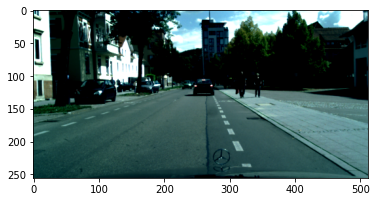

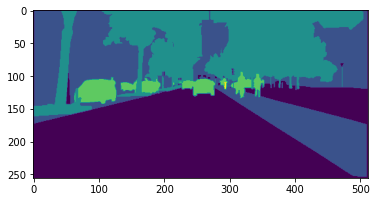

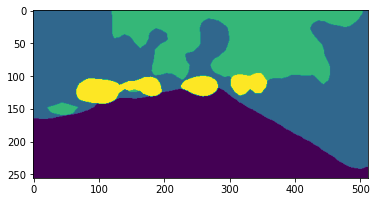

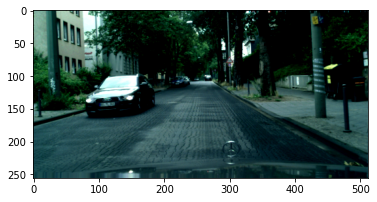

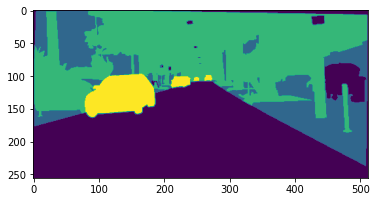

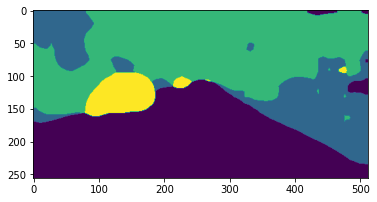

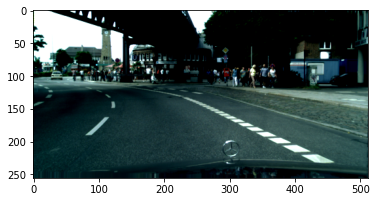

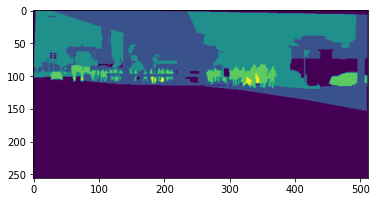

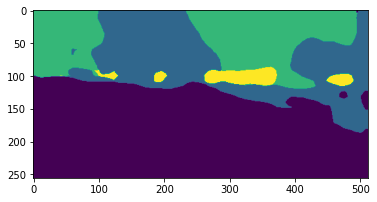

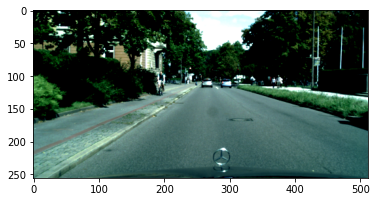

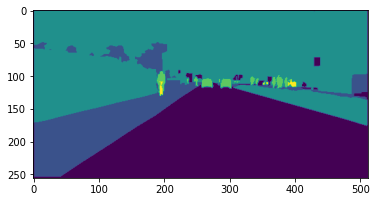

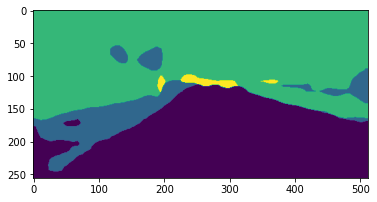

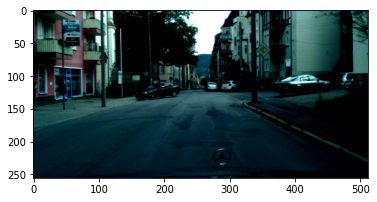

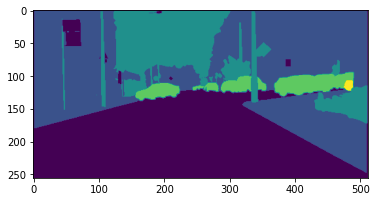

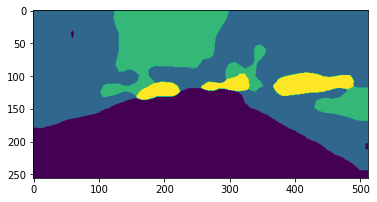

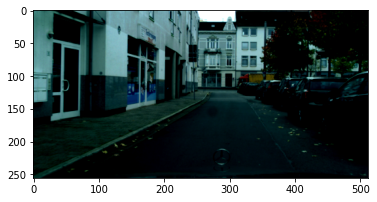

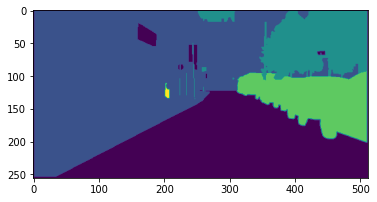

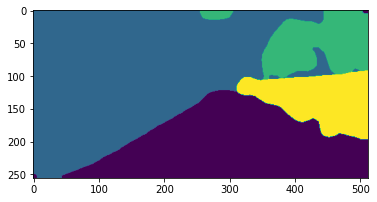

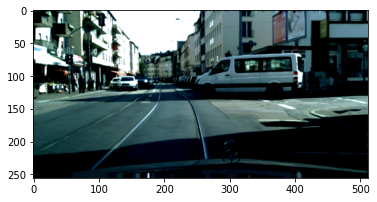

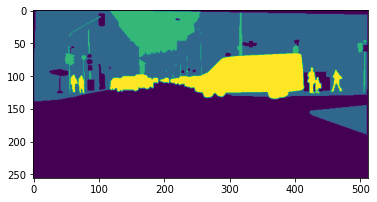

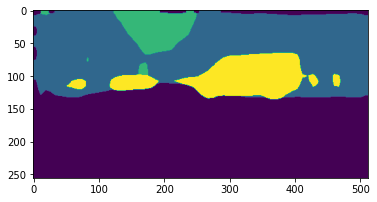

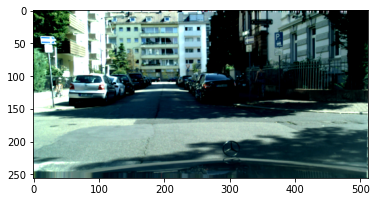

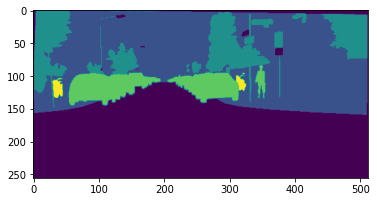

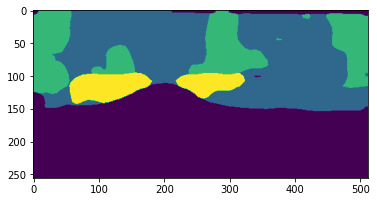

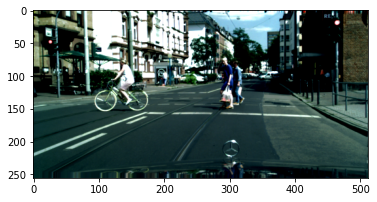

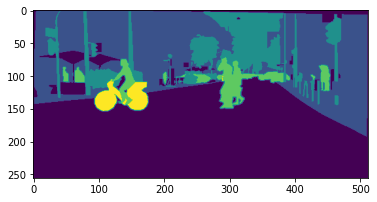

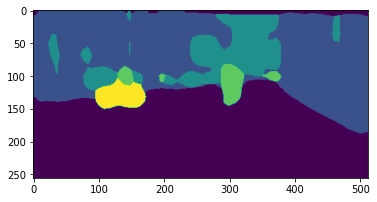

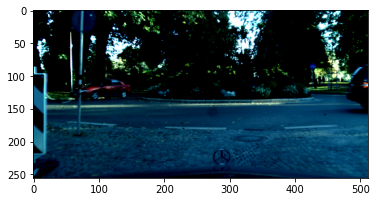

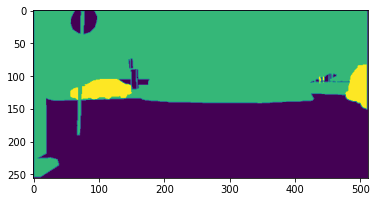

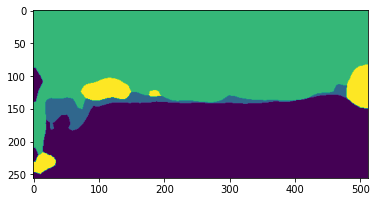

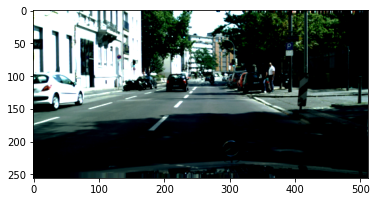

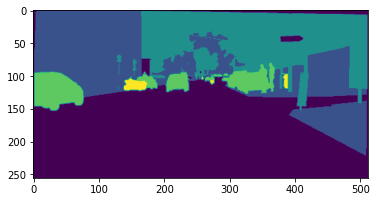

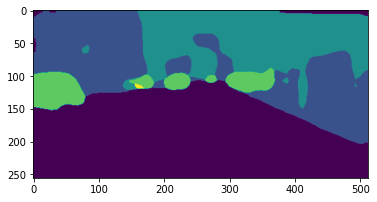

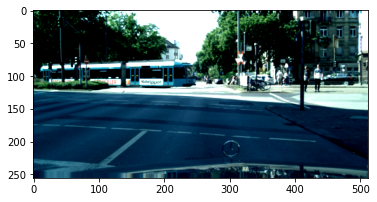

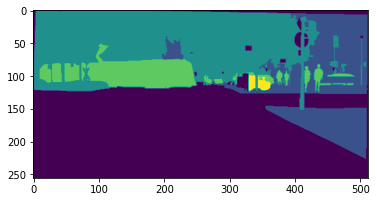

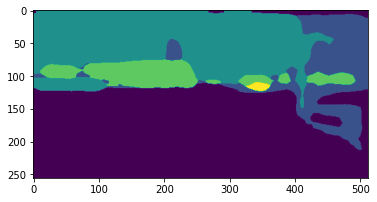

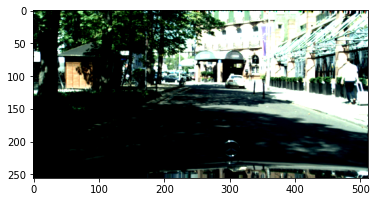

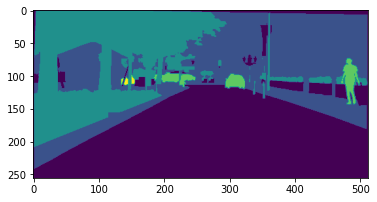

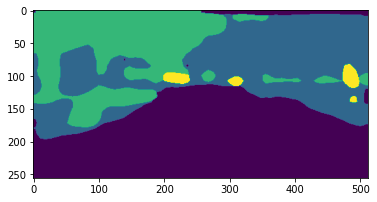

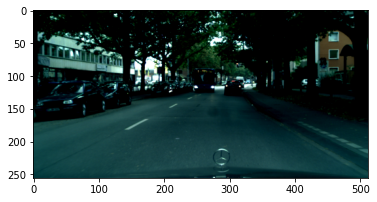

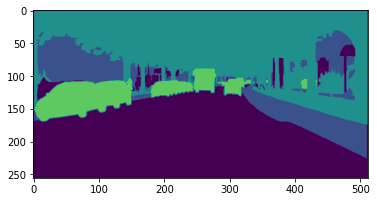

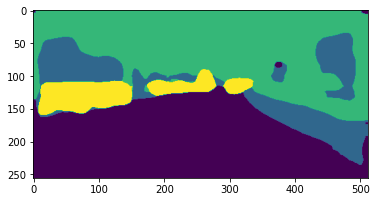

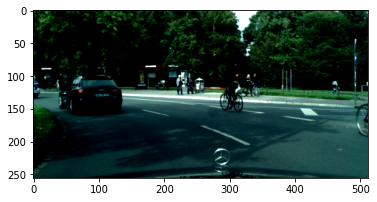

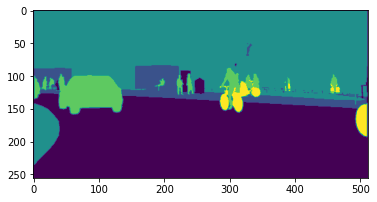

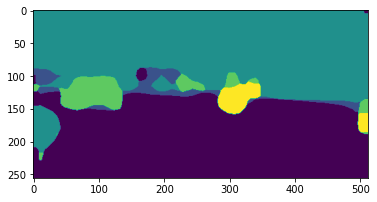

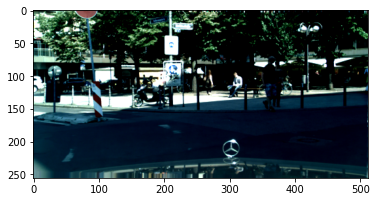

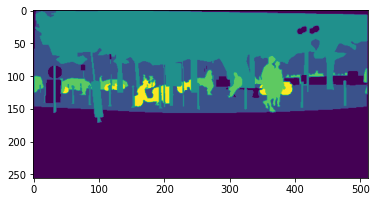

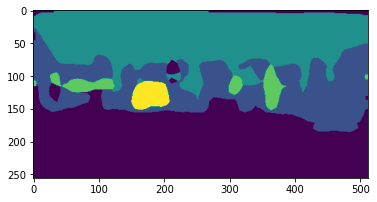

In [10]:
from torch.optim import lr_scheduler

#Load parameters
file_name = 'savedata/task3/task_3_model_parameters-14_03_2021-01.pt'
if os.path.isfile(file_name):
    model = torch.load(file_name)

#Statistical parameters
train_loss = 0.0
train_loss_history = []
validation_loss = 0.0
validation_loss_history = []
learning_rate_history = []

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.05, patience=5, verbose=True)

# Iterate over every epoch
for epoch in range(epochs):
    # Train model
    if train:
        train_loss = train_model(epoch, train_loader)
        train_loss_history.append(train_loss)

    # Validate model
    if validate:
        validation_loss = validate_model(epoch, validation_loader)
        validation_loss_history.append(validation_loss)

    # Learning rate history
    learning_rate_history.append(learning_rate)

    # Update Scheduler
    scheduler.step(validation_loss)

    torch.save(model, file_name)

print("Finished train model!")

#### Print lists of mean losses and scheduled learning for every epoch

In [11]:
print("Train loss of every epoch: " + str(train_loss_history))
print("Validation loss of every epoch: " + str(validation_loss_history))
print("Learning rate of every epoch: " + str(learning_rate_history))

Train loss of every epoch: [0.05933103212789327]
Validation loss of every epoch: [0.03950984156131744]
Learning rate of every epoch: [0.0002]


## 6) Evaluation

#### Evaluation metrics

In [12]:
from scipy import spatial
import sklearn.metrics as metrics


def one_row(ground_truth, prediction):
    pred = prediction.argmax(dim=1).view(1,-1)
    pred = np.squeeze(pred.numpy())

    truth = ground_truth.view(1,-1)
    truth = np.squeeze(truth.numpy())

    return truth.astype(float), pred.astype(float)


def performance(multi_confusion_matrix, class_labels):
    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []

    for i in class_labels:
        true_positive.append(multi_confusion_matrix[i][[0],[0]][0])
        false_positive.append(multi_confusion_matrix[i][[0],[1]][0])
        true_negative.append(multi_confusion_matrix[i][[1],[1]][0])
        false_negative.append(multi_confusion_matrix[i][[1],[0]][0])

    positive = [true_positive, false_positive]
    negative = [true_negative, false_negative]

    return positive, negative


def evaluate(ground_truth, predictions):
    ground_truth2 = ground_truth.copy()
    predictions2 = predictions.copy()

    accuracy = 0.0
    f1_score = np.zeros(34, dtype='float')
    auc_score = 0.0
    dice_coefficient = 0.0

    listlen = min(len(ground_truth2),len(predictions2))

    for l in range(0, listlen):
        x = ground_truth2[l].cpu()
        y = predictions2[l].cpu()


        transform_tensors = one_row(x, y)

        class_labels = list(range(0, 34))

        multi_confusion_matrix = metrics.multilabel_confusion_matrix(transform_tensors[0], transform_tensors[1], labels=class_labels)

        performance_model = performance(multi_confusion_matrix, class_labels)

        positives = performance_model[0]
        negatives = performance_model[1]

        positives_total, negatives_total = 0,0
        true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0

        for i in class_labels:
            positives_total += positives[0][i] + positives[1][i]
            negatives_total += negatives[0][i] + negatives[1][i]

            true_positives += positives[0][i]
            false_positives += positives[1][i]
            true_negatives += negatives[0][i]
            false_negatives += negatives[1][i]

        # Accuracy
        if (positives_total + negatives_total) != 0:
            accuracy += (true_positives + true_negatives) / (positives_total + negatives_total)


        # F1 score
        f1 = []
        for i in class_labels:
            denominator = 2 * positives[0][i] + positives[1][i] + negatives[1][i]
            if denominator != 0:
                f1.append(2 * positives[0][1] / denominator)
            else:
                f1.append(0.0)

        f1_score += f1


        # AUC-ROC score
        #auc_score += metrics.roc_auc_score(transform_tensors[0], transform_tensors[1], multi_class='ovr', labels=class_labels)


        # DICE coefficient
        if (2 * true_positives + false_positives + false_negatives) != 0:
            dice_coefficient += (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)


    accuracy = accuracy / listlen
    f1_score = f1_score / listlen
    auc_score = auc_score / listlen
    dice_coefficient = dice_coefficient / listlen

    return accuracy, f1_score, auc_score, dice_coefficient

#### Evaluation

In [13]:
f1_score = -1000.0
auc_score = -1000.0
dice_coefficient = -1000.0

truth_list = []
pred_list = []

In [14]:
#Only during the programming. We dont want want to build the testlist every time
breaker = False

if evaluate:
    testloader_loop = tqdm(validation_loader)

    #Set model mode to evaluation
    model.eval()

    #Iterate over all batches in validation_loader
    for i, batch in enumerate(testloader_loop):
        if breaker:
            break
        #Input Image for forward pass
        test_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        ground_truth = batch[1].cpu()
        ground_truth = ground_truth.squeeze(1)

        #Forward propagation
        with torch.no_grad():
            prediction = model(test_image)['out']

        truth_list.append(ground_truth.float())
        pred_list.append(prediction.cpu().float())

    scores = evaluate(truth_list, pred_list)

    accuracy = scores[0]
    f1_score = scores[1]
    auc_score = scores[2]
    dice_coefficient = scores[3]

    print("Finished evaluation!")

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Finished evaluation!


#### Print lists of scores

In [15]:
print("Accuracy: " + str(round((accuracy*100), 2)) + "%")
print("F1 score: " + str(f1_score*100) + "%")
print("AUC score: " + str(round((auc_score*100), 2)) + "%")
print("DICE coefficient: " + str(round((dice_coefficient*100), 2)) + "%")

Accuracy: 99.32%
F1 score: [120.59422844  93.48965777  85.95852511  73.15131739  68.19909986
  67.76547699  67.76547699  67.76547699  67.76547699  67.76547699
  67.76547699  67.76547699  67.76547699  67.76547699  67.76547699
  67.76547699  67.76547699  67.76547699  67.76547699  67.76547699
  67.76547699  67.76547699  67.76547699  67.76547699  67.76547699
  67.76547699  67.76547699  67.76547699  67.76547699  67.76547699
  67.76547699  67.76547699  67.76547699  67.76547699]%
AUC score: 0.0%
DICE coefficient: 99.65%


#### Evaluation plots

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

 38%|███▊      | 19/50 [00:16<00:27,  1.14it/s]


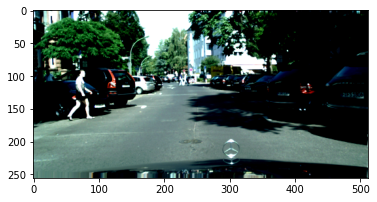

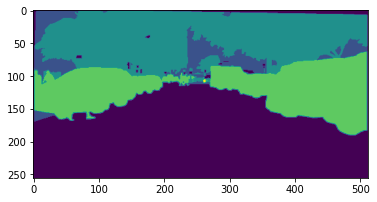

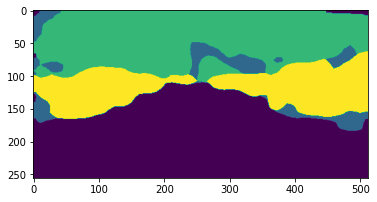

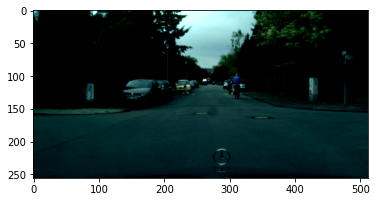

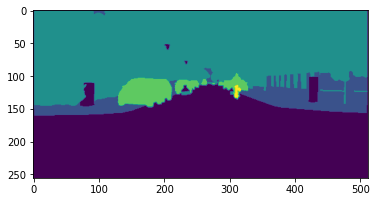

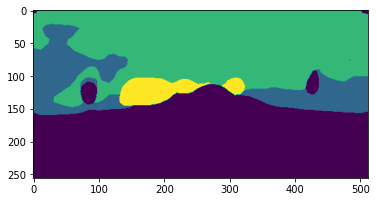

KeyboardInterrupt: 

In [17]:
model.eval()

testloader_loop = tqdm(validation_loader)

for i, batch in enumerate(testloader_loop):
    if i % 10 == 0:
        input_image = batch[0].to(device)
        label_mask = batch[1].squeeze(1)

        with torch.no_grad():
            output_model = model(input_image.to(device))['out']

        # print images
        image2 = input_image.cpu()
        imshow(torchvision.utils.make_grid(image2[0]))

        label2 = label_mask.cpu()

        plt.imshow(label2.detach().numpy()[0])
        plt.show()

        output2 = output_model.cpu()
        output3 = output2.argmax(dim=1)

        plt.imshow(output3.detach().numpy()[0])
        plt.show()

